In [1]:
!pip install nltk keras-tuner

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import string
import re
from html import unescape

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight

import keras_tuner as kt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nebul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Cantidad de na en keywords y location
train_df.isna().sum()
test_df.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

# Tratamiento de las columnas keyword y location para evitar NaN

In [5]:
train_df = train_df.drop(columns=['id'], axis=1)
test_df = test_df.drop(columns=['id'], axis=1)
# Llena los NaN en 'keyword' y 'location' con 'unknown'
train_df['keyword'] = train_df['keyword'].fillna('unknown')
train_df['location'] = train_df['location'].fillna('unknown')

test_df['keyword'] = test_df['keyword'].fillna('unknown')
test_df['location'] = test_df['location'].fillna('unknown')

In [6]:
train_df.head()

,keyword,location,text,target
0,unknown,unknown,Our Deeds are the Reason of this #earthquake M...,1
1,unknown,unknown,Forest fire near La Ronge Sask. Canada,1
2,unknown,unknown,All residents asked to 'shelter in place' are ...,1
3,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1
4,unknown,unknown,Just got sent this photo from Ruby #Alaska as ...,1


# Extraer atributos para análisis del texto

In [7]:
def word_count(text):
    return len(text.split())

def char_count(text):
    return len(text)

def avg_word_length(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return sum(len(w) for w in words) / len(words)

def count_hashtags(text):
    return text.count('#')

def count_mentions(text):
    return text.count('@')

def count_urls(text):
    return len(re.findall(r'http\S+|www\S+', text))

In [8]:
train_df["word_count"] = train_df["text"].apply(word_count)
train_df["char_count"] = train_df["text"].apply(char_count)
train_df["avg_word_length"] = train_df["text"].apply(avg_word_length)
train_df["hashtags"] = train_df["text"].apply(count_hashtags)
train_df["mentions"] = train_df["text"].apply(count_mentions)
train_df["urls"] = train_df["text"].apply(count_urls)

train_df.head()

,keyword,location,text,target,word_count,char_count,avg_word_length,hashtags,mentions,urls
0,unknown,unknown,Our Deeds are the Reason of this #earthquake M...,1,13,69,4.384615,1,0,0
1,unknown,unknown,Forest fire near La Ronge Sask. Canada,1,7,38,4.571429,0,0,0
2,unknown,unknown,All residents asked to 'shelter in place' are ...,1,22,133,5.090909,0,0,0
3,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1,8,65,7.125000,1,0,0
4,unknown,unknown,Just got sent this photo from Ruby #Alaska as ...,1,16,88,4.500000,2,0,0


# Distribución de palabras

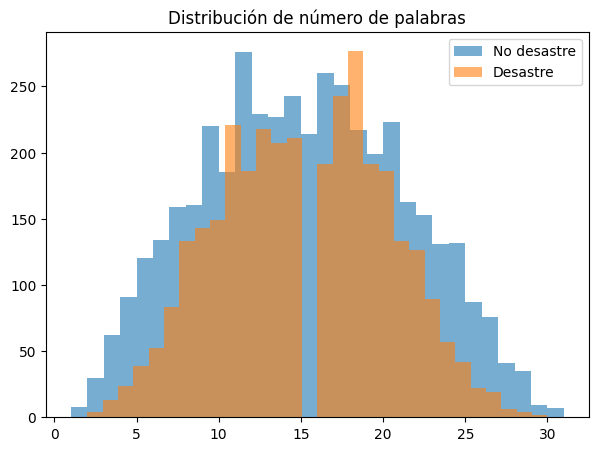

In [9]:
fig, ax = plt.subplots(figsize=(7,5))
ax.hist(train_df[train_df.target==0]["word_count"], bins=30, alpha=0.6, label="No desastre")
ax.hist(train_df[train_df.target==1]["word_count"], bins=30, alpha=0.6, label="Desastre")
ax.set_title("Distribución de número de palabras")
ax.legend()
plt.show()

# Distribución de carácteres

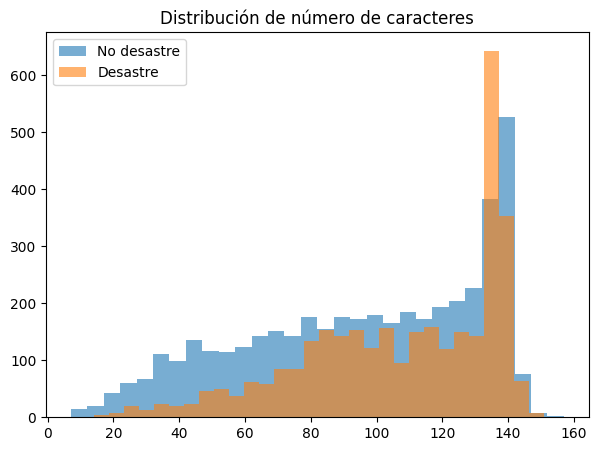

In [10]:

fig, ax = plt.subplots(figsize=(7,5))
ax.hist(train_df[train_df.target==0]["char_count"], bins=30, alpha=0.6, label="No desastre")
ax.hist(train_df[train_df.target==1]["char_count"], bins=30, alpha=0.6, label="Desastre")
ax.set_title("Distribución de número de caracteres")
ax.legend()
plt.show()

# Extracción de stopwords

In [11]:
stop = set(stopwords.words("english"))

def extract_stopwords(df):
    all_words = " ".join(df["text"]).lower().split()
    stops = [w for w in all_words if w in stop]
    return Counter(stops).most_common(20)

sw_disaster = extract_stopwords(train_df[train_df.target==1])
sw_not_disaster = extract_stopwords(train_df[train_df.target==0])

sw_disaster, sw_not_disaster

([('the', 1330),
  ('in', 1144),
  ('of', 919),
  ('a', 897),
  ('to', 753),
  ('and', 494),
  ('on', 410),
  ('for', 394),
  ('is', 344),
  ('at', 303),
  ('i', 284),
  ('by', 274),
  ('from', 243),
  ('with', 188),
  ('that', 181),
  ('after', 181),
  ('this', 177),
  ('as', 167),
  ('are', 166),
  ('was', 165)],
 [('the', 1877),
  ('a', 1238),
  ('to', 1181),
  ('i', 1052),
  ('and', 911),
  ('of', 895),
  ('in', 805),
  ('you', 625),
  ('is', 586),
  ('my', 541),
  ('for', 486),
  ('on', 424),
  ('with', 374),
  ('that', 357),
  ('it', 341),
  ('this', 286),
  ('be', 284),
  ('have', 240),
  ('by', 240),
  ('so', 235)])

# Distribución stopwords

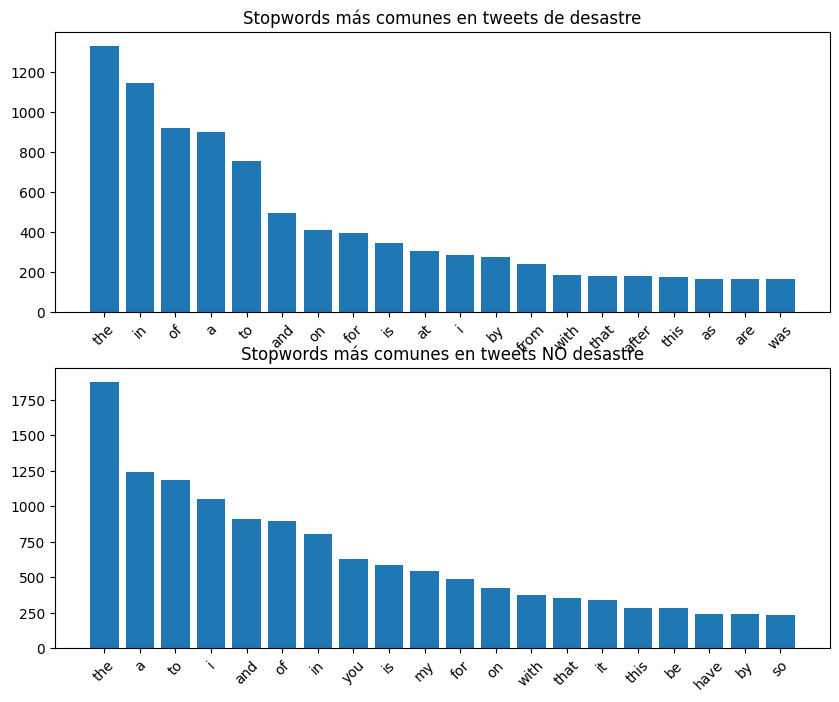

In [12]:
plt.figure(figsize=(10,8))

plt.subplot(2, 1, 1)
words = [w for w, _ in sw_disaster]
counts = [c for _, c in sw_disaster]
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Stopwords más comunes en tweets de desastre")

plt.subplot(2, 1, 2)
words = [w for w, _ in sw_not_disaster]
counts = [c for _, c in sw_not_disaster]
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Stopwords más comunes en tweets NO desastre")

plt.show()

# Distribución de signos de puntuación

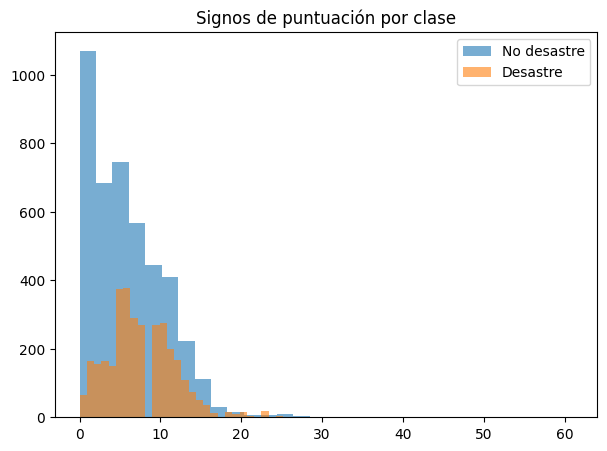

In [13]:
def punctuation_count(text):
    return sum(1 for c in text if c in string.punctuation)

train_df["punct_count"] = train_df["text"].apply(punctuation_count)

fig, ax = plt.subplots(figsize=(7,5))
ax.hist(train_df[train_df.target==0]["punct_count"], bins=30, alpha=0.6, label="No desastre")
ax.hist(train_df[train_df.target==1]["punct_count"], bins=30, alpha=0.6, label="Desastre")
ax.legend()
ax.set_title("Signos de puntuación por clase")
plt.show()

## Ngramas previos a la limpieza

In [14]:
vectorizer = CountVectorizer(ngram_range=(2,2), max_features=20)
bigrams = vectorizer.fit_transform(train_df["text"])

list(vectorizer.vocabulary_.keys())

['of the',
 'in the',
 'this is',
 'http co',
 'at the',
 'it was',
 'on the',
 'you re',
 'for the',
 'https co',
 'to be',
 'if you',
 'and the',
 'is the',
 'û_ http',
 'going to',
 'to the',
 'have been',
 'by the',
 'suicide bomber']

# Limpieza del texto (stopwords, lemmatización, etc)

In [15]:
stop = set(stopwords.words("english"))
lemmatizer = nltk.WordNetLemmatizer()
def clean_text(text):
    text = unescape(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = text.encode("ascii", "ignore").decode()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop and len(w) > 2]
    
    
    
    return " ".join(words)

train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)

train_df.head()

,keyword,location,text,target,word_count,char_count,avg_word_length,hashtags,mentions,urls,punct_count,clean_text
0,unknown,unknown,Our Deeds are the Reason of this #earthquake M...,1,13,69,4.384615,1,0,0,1,deed reason may allah forgive
1,unknown,unknown,Forest fire near La Ronge Sask. Canada,1,7,38,4.571429,0,0,0,1,forest fire near ronge sask canada
2,unknown,unknown,All residents asked to 'shelter in place' are ...,1,22,133,5.090909,0,0,0,3,resident asked shelter place notified officer ...
3,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1,8,65,7.125000,1,0,0,2,13000 people receive evacuation order california
4,unknown,unknown,Just got sent this photo from Ruby #Alaska as ...,1,16,88,4.500000,2,0,0,2,got sent photo ruby smoke pours school


## Visualización de Ngramas tras limpieza

Ahora se nota una gran diferencia con las palabras vectorizadas, habiéndose eliminado las stopwords, siendo ahora todo pares de palabras que dan valor sobre el contexto.

In [16]:
vectorizer_clean = CountVectorizer(ngram_range=(2,2), max_features=20)
bigrams_clean = vectorizer_clean.fit_transform(train_df["clean_text"])

list(vectorizer_clean.vocabulary_.keys())


['heat wave',
 'look like',
 'feel like',
 'liked video',
 'full read',
 'northern california',
 'suicide bombing',
 'california wildfire',
 'cross body',
 'body bag',
 'burning building',
 'confirmed mh370',
 'natural disaster',
 'first responder',
 'mass murder',
 'oil spill',
 'home razed',
 'pkk suicide',
 'suicide bomber',
 'bomber detonated']

# Procesamiento de texto

In [ ]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Decodificar HTML
    text = unescape(text)
    
    # Reemplazar URLs por token especial
    text = re.sub(r'http\S+|www\S+|https\S+', ' URL ', text)
    
    # Reemplazar @mentions por token especial
    text = re.sub(r'@\w+', ' MENTION ', text)
    
    # Mantener hashtags pero quitar el # (las palabras pueden ser importantes)
    text = re.sub(r'#(\w+)', r' HASHTAG \1 ', text)
    
    # Reemplazar números por token (pero mantener contexto de números en desastres)
    text = re.sub(r'\d+', ' NUMBER ', text)
    
    # Normalizar espacios múltiples
    text = re.sub(r'\s+', ' ', text)
    
    # Expandir contracciones comunes
    contractions = {
        "can't": "cannot", "won't": "will not", "n't": " not",
        "'re": " are", "'ve": " have", "'ll": " will",
        "'d": " would", "'m": " am"
    }
    for k, v in contractions.items():
        text = text.replace(k, v)
    
    # Quitar puntuación (excepto ! y ? que pueden indicar urgencia)
    text = re.sub(r'[^\w\s!?]', ' ', text)
    
    # Limpiar espacios finales
    text = text.strip()
    
    return text

In [18]:
train_df["preprocessed_text"] = train_df["clean_text"].apply(preprocess_text)
test_df["preprocessed_text"] = test_df["clean_text"].apply(preprocess_text)

# Data Augmentation

In [19]:
import random

def augment_text(text, prob=0.25):
    """Simple data augmentation: elimina palabras aleatoriamente"""
    words = text.split()
    if len(words) <= 3:
        return text
    
    # Eliminar palabras con probabilidad prob
    augmented = [w for w in words if random.random() > prob]
    return ' '.join(augmented) if augmented else text

# Aplicar solo a tweets de desastre (clase minoritaria)
disaster_tweets = train_df[train_df['target'] == 1]
augmented_texts = disaster_tweets['text'].apply(lambda x: augment_text(x, prob=0.25))

# Concatenar al dataset original
train_df = pd.concat([
    train_df,
    disaster_tweets.copy().assign(text=augmented_texts)
], ignore_index=True)

# Vectorización y Ngramas

In [20]:
tfidf = TfidfVectorizer(
    max_features=10000,         
    ngram_range=(1, 3),          # Uni, bi y trigramas
    min_df=2,                    # Palabra debe aparecer en al menos 2 docs
    max_df=0.8,                  # Ignorar palabras en más del 80% docs
    sublinear_tf=True,           # Escala logarítmica de frecuencias
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{2,}',     # Palabras de al menos 2 caracteres
    stop_words='english'         # Usa stopwords de sklearn
)
X = tfidf.fit_transform(train_df["preprocessed_text"])

from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

# Codificar la columna 'keyword'
enc = OneHotEncoder(handle_unknown='ignore')
keyword_encoded_train = enc.fit_transform(train_df[['keyword', 'location']])
keyword_encoded_test = enc.transform(test_df[['keyword', 'location']])

# Eliminar columnas originales
train_df = train_df.drop(columns=['keyword', 'location'], axis=1)
test_df = test_df.drop(columns=['keyword', 'location'], axis=1)

# Combinar TF-IDF con keyword codificado
X = hstack([X, keyword_encoded_train])
X_test = hstack([tfidf.transform(test_df["preprocessed_text"]), keyword_encoded_test])

y = train_df["target"]

## Palabras más repetidas en desastres

In [21]:
most_common_words_target = Counter(" ".join(train_df[train_df.target==1]["preprocessed_text"]).split()).most_common(20)
most_common_words_target

[('NUMBER', 1804),
 ('fire', 528),
 ('via', 242),
 ('california', 222),
 ('suicide', 220),
 ('disaster', 220),
 ('police', 212),
 ('people', 210),
 ('family', 210),
 ('home', 202),
 ('train', 200),
 ('building', 188),
 ('killed', 184),
 ('like', 184),
 ('bomb', 182),
 ('storm', 178),
 ('crash', 176),
 ('news', 172),
 ('year', 170),
 ('attack', 152)]

# Características extras del texto

In [ ]:

def add_text_features(df):
    features = pd.DataFrame()
    
    # Longitud del texto
    features['text_length'] = df['text'].str.len()
    features['word_count'] = df['text'].str.split().str.len()
    
    # Mayúsculas (tweets urgentes suelen tener más)
    features['uppercase_ratio'] = df['text'].apply(
        lambda x: sum(1 for c in str(x) if c.isupper()) / max(len(str(x)), 1)
    )
    
    # Signos de exclamación y puntuación
    features['exclamation_count'] = df['text'].str.count('!')
    features['question_count'] = df['text'].str.count(r'\?')
    
    # URLs y menciones
    features['url_count'] = df['text'].str.count(r'http|www')
    features['mention_count'] = df['text'].str.count(r'@')
    features['hashtag_count'] = df['text'].str.count(r'#')
    
    # Normalizar
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    return features_scaled, scaler

# Agregar features adicionales
train_df_feat, scaler_train = add_text_features(train_df)
test_df_feat, _ = add_text_features(test_df)

# Combina TF-IDF con features adicionales
from scipy.sparse import hstack
X_train_combined = hstack([X, train_df_feat])
X_test_combined = hstack([X_test, test_df_feat])

# División del dataset

In [23]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_combined, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_val.shape

((8707, 13572), (2177, 13572))

## Dimensionalidad de entrada

In [24]:
input_dim = X_train.shape[1]

# Crear el modelo con Keras-tuner

In [ ]:
def build_model(hp, input_dim):
    model = models.Sequential()
    
    # Primera capa, más grande
    model.add(layers.Dense(
        hp.Int('units_1', min_value=256, max_value=768, step=128),
        activation='relu',
        input_shape=(input_dim,)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_1', 0.3, 0.6, step=0.1)))
    
    # Segunda capa
    model.add(layers.Dense(
        hp.Int('units_2', min_value=128, max_value=512, step=128),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))
    
    # Tercera capa opcional (ayuda con patrones complejos)
    if hp.Boolean('use_third_layer'):
        model.add(layers.Dense(
            hp.Int('units_3', min_value=64, max_value=256, step=64),
            activation='relu'
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(hp.Float('dropout_3', 0.2, 0.4, step=0.1)))
    
    # Capa de salida
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Optimizador con learning rate ajustable
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.F1Score(name='f1_score')
        ]
    )
    return model

# Dar peso a las clases

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights_computed = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Ajustar manualmente
class_weights = {
    0: class_weights_computed[0],
    1: class_weights_computed[1] * 1.2  # Boost adicional a la clase de desastres
}

# Callbacks

In [27]:
# Early stopping más paciente
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# ReduceLROnPlateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,               # Reducir a la mitad
    patience=5,
    min_lr=1e-6,
    mode='max',
    verbose=1
)

# Entrenamiento Keras-Tuner

In [ ]:
# Busqueda con kt
tuner = kt.BayesianOptimization(
    hypermodel=lambda hp: build_model(hp, input_dim), # Pasar a la función build_model el hp e input_dim
    objective=kt.Objective('val_accuracy', direction='max'),  # Maximizar accuracy
    max_trials=30,           # Número de configuraciones a probar
    executions_per_trial=1,  # Veces que se entrena cada configuración
    directory='tuner_results',
    project_name='disaster_tweets_optimization',
    overwrite=True
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Trial 30 Complete [00h 03m 52s]
val_accuracy: 0.8934313058853149

Best val_accuracy So Far: 0.9035369753837585
Total elapsed time: 02h 32m 26s


## Obtener mejores hiperparámetros

In [29]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Crear un modelo con los mejores hiperparámetros y entrenar

In [30]:
# Construir el modelo con esos parámetros
model = build_model(best_hp, input_dim)

# Entrenar el mejor modelo
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.6992 - auc: 0.7643 - f1_score: 0.7511 - loss: 0.7086 - precision: 0.7711 - recall: 0.7110 - val_accuracy: 0.8129 - val_auc: 0.8883 - val_f1_score: 0.7477 - val_loss: 0.5292 - val_precision: 0.8635 - val_recall: 0.8154 - learning_rate: 0.0017
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8731 - auc: 0.9426 - f1_score: 0.7511 - loss: 0.3365 - precision: 0.9152 - recall: 0.8697 - val_accuracy: 0.8473 - val_auc: 0.9223 - val_f1_score: 0.7477 - val_loss: 0.3660 - val_precision: 0.9161 - val_recall: 0.8192 - learning_rate: 0.0017
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9315 - auc: 0.9798 - f1_score: 0.7511 - loss: 0.1959 - precision: 0.9519 - recall: 0.9332 - val_accuracy: 0.8680 - val_auc: 0.9337 - val_f1_score: 0.7477 - val_loss: 0.3772 - val_precision: 0.8978 - val_recall: 0.8788 - learning_rate: 0.0017
Epoch 4/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.95

# Evolución de loss en train y validation

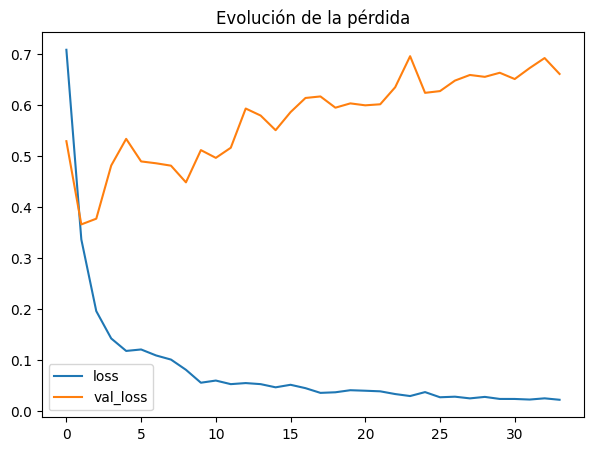

In [31]:
plt.figure(figsize=(7,5))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Evolución de la pérdida")
plt.legend()
plt.show()

# Resultados de las métricas

In [32]:
# Retorna un diccionario con los nombres de las métricas
results = model.evaluate(X_val, y_val, verbose=1, return_dict=True)

for metric_name, value in results.items():
    print(f"{metric_name:15s}: {value:.4f}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8769 - auc: 0.9201 - f1_score: 0.7510 - loss: 0.6363 - precision: 0.8813 - recall: 0.9190
accuracy       : 0.8769
auc            : 0.9201
f1_score       : 0.7510
loss           : 0.6363
precision      : 0.8813
recall         : 0.9190


# Ajuste del threshold para obtener mejores resultados

In [33]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Predecir probabilidades en el set de validación
y_val_prob = model.predict(X_val, verbose=0)

# Buscar el umbral que maximiza el F1
thresholds = np.arange(0.1, 0.9, 0.001)
best_threshold = 0.5
best_f1 = 0
best_accuracy = 0
best_precision = 0
best_recall = 0

for t in thresholds:
    # Convertir probabilidad a clase 0 o 1 según el umbral t
    y_pred_temp = (y_val_prob > t).astype(int).flatten()
    score = f1_score(y_val, y_pred_temp)

    if score > best_f1:
        best_f1 = score
        best_threshold = t
        best_accuracy = accuracy_score(y_val, y_pred_temp)
        best_precision = precision_score(y_val, y_pred_temp)
        best_recall = recall_score(y_val, y_pred_temp)

# Generar predicciones finales con el mejor umbral
y_val_pred = (y_val_prob > best_threshold).astype(int).flatten()

# Mostrar resultados
print(f"Mejor Umbral:    {best_threshold:.3f}")
print(f"F1-Score:        {best_f1:.5f}")
print(f"Accuracy:        {best_accuracy:.5f}")
print(f"Precision:       {best_precision:.5f}")
print(f"Recall:          {best_recall:.5f}")

Mejor Umbral:    0.810
F1-Score:        0.90573
Accuracy:        0.88746
Precision:       0.91240
Recall:          0.89916


# Predicción sobre el conjunto de test y resultados

In [34]:
test_df["prediction_prob"] = model.predict(X_test_combined, verbose=0)
test_df["prediction"] = (test_df["prediction_prob"] > best_threshold).astype(int)

test_df[["text", "prediction", "prediction_prob"]].head(10)

,text,prediction,prediction_prob
0,Just happened a terrible car crash,1,0.996004
1,"Heard about #earthquake is different cities, s...",0,0.011512
2,"there is a forest fire at spot pond, geese are...",1,0.999677
3,Apocalypse lighting. #Spokane #wildfires,0,0.370101
4,Typhoon Soudelor kills 28 in China and Taiwan,1,0.836153
5,We're shaking...It's an earthquake,1,0.999516
6,They'd probably still show more life than Arse...,0,0.010364
7,Hey! How are you?,0,0.000034
8,What a nice hat?,0,0.000012
9,Fuck off!,0,0.000021


# Resultados con mayor confianza para desastres y no desastres

In [35]:
print("Ejemplos predichos como desastre:")
display(test_df.sort_values("prediction_prob", ascending=False).head(5)[["text","prediction_prob"]])

print("Ejemplos predichos como NO desastre:")
display(test_df.sort_values("prediction_prob", ascending=True).head(5)[["text","prediction_prob"]])


Ejemplos predichos como desastre:


,text,prediction_prob
3078,Watch: Violent Storm Causes Deadly Accident at...,1.0
2260,Refugio oil spill may have been costlier bigge...,1.0
709,Greece's tax revenues collapse as debt crisis ...,1.0
2263,Refugio oil spill may have been costlier bigge...,1.0
1908,Udhampur terror attack: Militants attack polic...,1.0


Ejemplos predichos como NO desastre:


,text,prediction_prob
825,@DancingOnHwy there is nothing I love more tha...,1.776134e-07
400,@JeremyClarkson buy a new one bloody ell,2.314362e-07
1411,@snackwave_julie When You Are Engulfed in Cake...,3.981294e-07
2211,@Wadeycakes @ThunderCastTV you're right Thunde...,4.532489e-07
2200,@MilesWithTate but seeing the writers oblitera...,6.880691e-07


# Conclusiones
El problema que se busca abarcar es muy difícil de tratar usando una arquitectura de capas densas simple, aún así es posible.
Para tratar de combatir ese problema, he buscado aumentar el dataset de positivos (desastres) para así poderle dar mayor número de ejemplos distintos al modelo durante el entrenamiento. Para ello se ha aplicado Data Augmentation sobre el conjunto de entrenamiento, eliminando palabras aleatorias solamente en los casos afirmativos.

## Análisis del texto
Tanto positivos como negativos tienen una estructura de texto bastante similar, dejando ver unas distribuciones dentro del texto (longitud, carácteres, etc) que en general son casi idénticas, solamente teniendo una diferencia notable en el uso de stopwords y signos de puntuación, donde la diferencia es gigantesca.

Se han utilizado estos atributos para entrenar la red, para así poderle dar más información.

## Vectorización y Ngramas
En cuanto a la vectorización y ngramas, en base a prueba y error he llegado a la conclusión de que estos son los parámetros que mejores resultados han dado, definiendo 10000 features a vectorizar y crear ngramas de 2 y 3 palabras (bigramas y trigramas) de las palabras que tengan mayor presencia juntas.

## Modelo
El modelo consiste en 2 capas densas, con sus respectivas capas de normalización (BatchNormalization), dropout para evitar el sobreajuste en el entrenamiento; el cual era muy grande, llegando a dar 0.99 en entrenamiento y 0.7 en validación aproximadamente; y activación ReLU, estas capas están de forma permanente. Luego hay una capa opcional que, según los resultados de Keras-tuner, será utilizada o no. Al final el modelo termina con una capa densa con una única neurona y función de activación sigmoide para la clasificación binaria.

La estructura que se sigue es de mayor a menor número de neuronas por capa, para de esta manera ir condensando la información de los resultados en una menor cantidad de neuronas cada vez, hasta llegar a la neurona de salida.

# Métricas
Las métricas seleccionadas son loss, accuracy, auc, precission, recall y f1_score, para poder tener una visión completa de todos los puntos de vista, no solamente el número de aciertos. No sé por qué pero f1_score no funciona bien y devuelve siempre el mismo resultado, así que lo voy a obviar. Para el resto de métricas, la idea es poder tener una idea de cual va a ser el f1_score de verdad debido a que este se basa en los resultados de precission y recall.

# Pesos de los atributos
Para esto he utilizado la función compute_class_weight, que se encarga de darle pesos a los atributos según la clase a la que le dan mayor peso, que puede llegar a variar. Para una mayor importancia sobre el conjunto de positivos, he decidido darle un "boost" a los atributos que tienen mayor peso para clasificar desastre.

# Callbacks
He seleccionado los callbacks de earlystopping y reduce_lr para poder parar el entrenamiento a tiempo sin que el modelo caiga en overfitting y para que pueda ir variando el learning rate, a uno cada vez menor, para poder ajustar de mejor manera los parámetros del modelo al calcular los nuevos pesos.

# Primeros resultados
Como primeras métricas al predecir sobre el conjunto que no ha visto en el entrenamiento, consigue un resultado muy bueno de accuraccy pero uno muy malo de f1_score, eso es debido a que el f1_score se calcula a partir de precission y de recall, que estos a su vez se basan en el número de verdaderos positivos, falsos positivos y falsos negativos que se han sacado, no solamente en el número de acertados total. Por lo que, para eso, se decide reajustar el threshold para ver si se puede obtener un mejor resultado.

# Resultados tras el ajuste
Tras el ajuste, basado únicamente en el resultado que da f1_score, se encuentra que el mejor threshold es 0.810 y eso da un resultado de 0.90573 de f1_score sin sacrificar el porcentaje de acertados totales que es 0.88746, lo cual es un increible resultado.